<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
DATA_DIR = '/kaggle/input/faces-dataset-small'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def get_dataloader(image_size, batch_size):
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_dl = get_dataloader(image_size, batch_size)

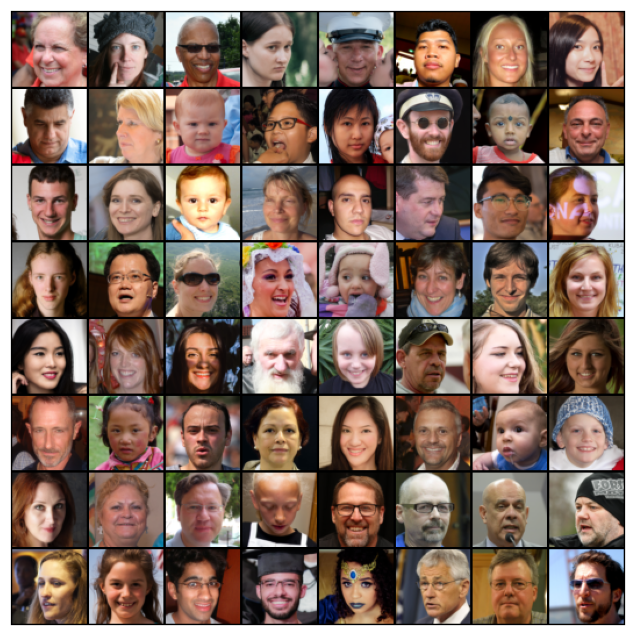

In [3]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(train_dl)

In [4]:
image_size = 128

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [5]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
discriminator = to_device(discriminator, device)

In [6]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)
generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


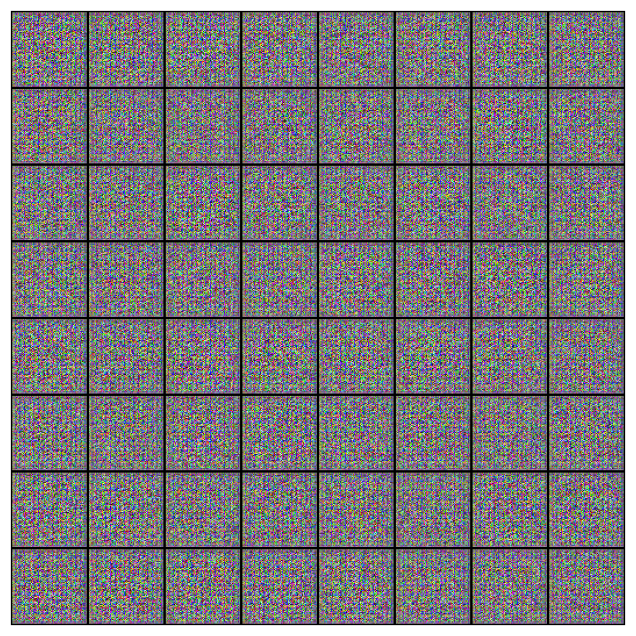

In [7]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [11]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [22]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, 40, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 4.2529, loss_d: 0.4066, real_score: 0.8581, fake_score: 0.1511


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 4.5562, loss_d: 0.2461, real_score: 0.8983, fake_score: 0.1004


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 5.0728, loss_d: 0.2774, real_score: 0.8976, fake_score: 0.1045


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 4.7271, loss_d: 0.2645, real_score: 0.8919, fake_score: 0.0994


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 5.4953, loss_d: 0.3281, real_score: 0.8895, fake_score: 0.1188


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.7544, loss_d: 0.3114, real_score: 0.8801, fake_score: 0.1141


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.8818, loss_d: 0.2651, real_score: 0.8912, fake_score: 0.0986


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.8050, loss_d: 0.2609, real_score: 0.9036, fake_score: 0.1081


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.8964, loss_d: 0.3178, real_score: 0.8718, fake_score: 0.1083


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.5274, loss_d: 0.2676, real_score: 0.8954, fake_score: 0.1079


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 3.9915, loss_d: 0.1877, real_score: 0.9170, fake_score: 0.0831


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.9801, loss_d: 0.6840, real_score: 0.8380, fake_score: 0.1612


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.4124, loss_d: 0.4169, real_score: 0.8454, fake_score: 0.1468


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 3.8225, loss_d: 0.2286, real_score: 0.9013, fake_score: 0.0986


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.2690, loss_d: 0.2093, real_score: 0.9105, fake_score: 0.0920


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.6790, loss_d: 0.3455, real_score: 0.8653, fake_score: 0.1190


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.5330, loss_d: 0.2999, real_score: 0.8846, fake_score: 0.1207


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.1479, loss_d: 0.2884, real_score: 0.8842, fake_score: 0.0988


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 5.1163, loss_d: 0.5461, real_score: 0.8410, fake_score: 0.1749


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.6088, loss_d: 0.2223, real_score: 0.9052, fake_score: 0.0963


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.3763, loss_d: 0.3122, real_score: 0.8817, fake_score: 0.1158


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.2511, loss_d: 0.2340, real_score: 0.8999, fake_score: 0.0998


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 4.3712, loss_d: 0.2774, real_score: 0.8894, fake_score: 0.1086


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.7525, loss_d: 0.5754, real_score: 0.8327, fake_score: 0.1599


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 3.9525, loss_d: 0.2189, real_score: 0.9076, fake_score: 0.0974


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
torch.save(model['discriminator'].state_dict(), 'disc1.pt')
torch.save(model['generator'].state_dict(), 'gen1.pt')

In [ ]:
history = fit(model, criterion, 40, lr)
torch.save(model['discriminator'].state_dict(), 'disc2.pt')
torch.save(model['generator'].state_dict(), 'gen2.pt')

In [ ]:
history = fit(model, criterion, 40, lr)
torch.save(model['discriminator'].state_dict(), 'disc3.pt')
torch.save(model['generator'].state_dict(), 'gen3.pt')

In [10]:
generator.load_state_dict(torch.load("/kaggle/working/gen3.pt"))

<All keys matched successfully>

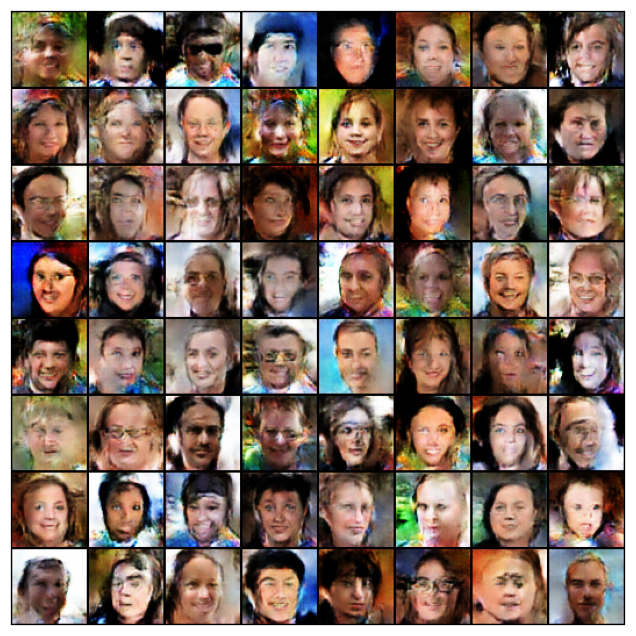

In [11]:
xb = torch.randn(batch_size, latent_size, 1, 1, device=device) 
fake_images = generator(xb)
show_images(fake_images.detach().cpu())

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
4.2529 0.4066
4.5562 0.2461
5.0728 0.2774
4.7271 0.2645
5.4953 0.3281
4.7544 0.3114
4.8818 0.2651
4.8050 0.2609
4.8964 0.3178
4.5274 0.2676
3.9915 0.1877
4.9801 0.6840
4.4124 0.4169
3.8225 0.2286
4.2690 0.2093
4.6790 0.3455
4.5330 0.2999
4.1479 0.2884
5.1163 0.5461
4.6088 0.2223
4.3763 0.3122
4.2511 0.2340
4.3712 0.2774
4.7525 0.5754
3.9525 0.2189

In [48]:
import io
msg = '''4.2529 0.4066
4.5562 0.2461
5.0728 0.2774
4.7271 0.2645
5.4953 0.3281
4.7544 0.3114
4.8818 0.2651
4.8050 0.2609
4.8964 0.3178
4.5274 0.2676
3.9915 0.1877
4.9801 0.6840
4.4124 0.4169
3.8225 0.2286
4.2690 0.2093
4.6790 0.3455
4.5330 0.2999
4.1479 0.2884
5.1163 0.5461
4.6088 0.2223
4.3763 0.3122
4.2511 0.2340
4.3712 0.2774
4.7525 0.5754
3.9525 0.2189'''
buf = io.StringIO(msg)
hist_gen = []
hist_disc = []
for _ in range(25):
    x, y = map(float, buf.readline().split())
    hist_gen.append(x)
    hist_disc.append(y)
print(hist_gen)

[4.2529, 4.5562, 5.0728, 4.7271, 5.4953, 4.7544, 4.8818, 4.805, 4.8964, 4.5274, 3.9915, 4.9801, 4.4124, 3.8225, 4.269, 4.679, 4.533, 4.1479, 5.1163, 4.6088, 4.3763, 4.2511, 4.3712, 4.7525, 3.9525]


ПРОСТО У МЕНЯ ВЫРУБИЛСЯ НОУТБУК ПОКА Я СТАВИЛ ОБУЧАТЬСЯ, ПЕРЕМЕННЫЕ СТЕРЛИСЬ ПРИХОДИТСЯ ДЕЛАТЬ ГРАФИК ПО ВЫВОДУ

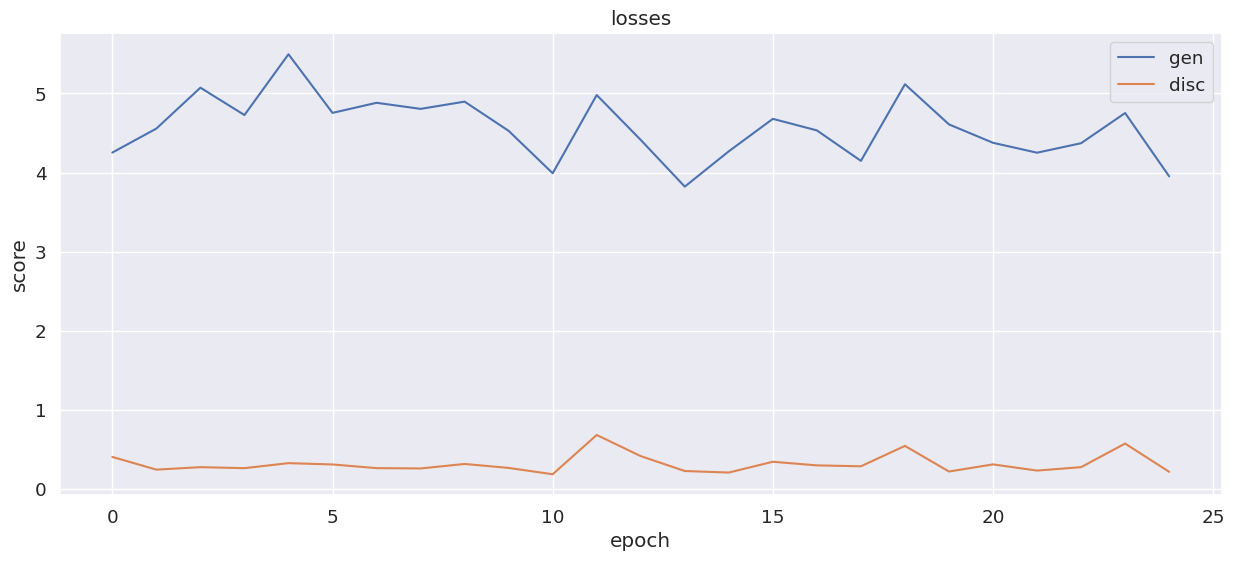

In [49]:
plt.figure(figsize=(15, 6))

plt.plot(hist_gen, '-')
plt.plot(hist_disc, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['gen', 'disc'])
plt.title('losses');

ГЕНЕРАТОР И ДИСКРИМИНАТОР НА КАКИХ-ТО ЭТАПАХ ДРУГ-ДРУГА ПЕРЕИГРЫВАЮТ -- ВСЕ КАК И ДОЛЖНО БЫТЬ****

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [13]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)

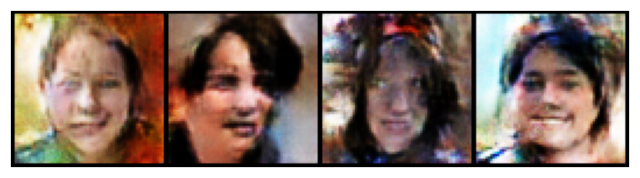

In [14]:
show_images(fake_images.detach().cpu())

Как вам качество получившихся изображений?

**Я тренировал 160 эпох. Уже видно различные черты лица, но пока-что много мяса**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [40]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
generator.eval()
nel = len(ImageFolder(DATA_DIR)) // 4
fixed_latent = torch.randn(nel, latent_size, 1, 1, device=device)
fake_images = generator(fixed_latent)
test_dl = get_dataloader(image_size//2, nel)
real_images, _ = next(iter(DeviceDataLoader(test_dl, device)))
all_images = torch.cat((fake_images, real_images), axis = 0)

In [45]:
all_images = all_images.detach().cpu().view(nel*2, -1)
labels = torch.cat((torch.zeros(nel), torch.ones(nel)), axis=0)
loo = LeaveOneOut()
accuracy = 0
for train_split, test_split in tqdm(loo.split(all_images)):
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(all_images[train_split], labels[train_split])
    accuracy += (neigh.predict(all_images[test_split]).item() == labels[test_split].item()) / nel
print(accuracy)

0it [00:00, ?it/s]

1.397452229299363


In [46]:
print(accuracy/2)

0.6987261146496815


**Модель в трети случаев не может правильно определить, так что думаю такой результат пойдет ведь максимум должно быть близко к 0.5.**

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

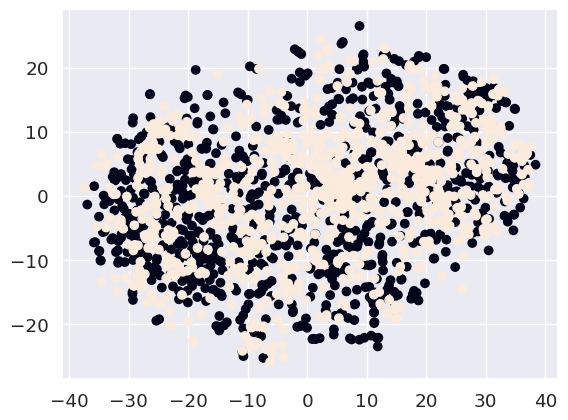

In [41]:
from sklearn.manifold import TSNE
all_images = all_images.detach().cpu().view(nel*2, -1)
embeded = TSNE().fit_transform(all_images)
plt.scatter(embeded[:, 0], embeded[:, 1], c = labels)

Прокомментируйте получившийся результат:

**Видно явное смешение, оно немного не однородно, так как в центре больше и по краям оно не такое смешенное как между этими зонами. Результат хороший**